# Loading and Preprocessing

### Refresher

Using PyTorch as compute engine and mpi4py for communication, Heat implements a number of array operations and algorithms that are optimized for memory-distributed data volumes. This allows you to tackle datasets that are too large for single-node (or worse, single-GPU) processing. 

As opposed to task-parallel frameworks, Heat takes a data-parallel approach, meaning that each "worker" or MPI process performs the same tasks on different slices of the data. Many operations and algorithms are not embarassingly parallel, and involve data exchange between processes. Heat operations and algorithms are designed to minimize this communication overhead, and to make it transparent to the user.

In other words: 
- you don't have to worry about optimizing data chunk sizes; 
- you don't have to make sure your research problem is embarassingly parallel, or artificially make your dataset smaller so your RAM is sufficient; 
- you do have to make sure that you have sufficient **overall** RAM to run your global task (e.g. number of nodes / GPUs).

The following shows some I/O and preprocessing examples. We'll use small datasets here as each of us only has access to one node only.

Your ipcluster should still be running (see the [Intro](0_setup/0_setup_local.ipynb)). Let's test it:

In [1]:
from ipyparallel import Client
rc = Client(profile="default")
rc.ids

[0, 1, 2, 3]

The above cell should return [0, 1, 2, 3].

Now let's import `heat`: 

In [2]:
%%px 
import heat as ht

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:1] /home/hopp_fa/heat/heat/core/_config.py:104: UserWarning: Heat has CUDA GPU-support (PyTorch version 2.7.1+cu126 and `torch.cuda.is_available() = True`), but CUDA-awareness of MPI could not be detected. This may lead to performance degradation as direct MPI-communication between GPUs is not possible.
  warnings.warn(


[stderr:0] /home/hopp_fa/heat/heat/core/_config.py:104: UserWarning: Heat has CUDA GPU-support (PyTorch version 2.7.1+cu126 and `torch.cuda.is_available() = True`), but CUDA-awareness of MPI could not be detected. This may lead to performance degradation as direct MPI-communication between GPUs is not possible.
  warnings.warn(


[stderr:3] /home/hopp_fa/heat/heat/core/_config.py:104: UserWarning: Heat has CUDA GPU-support (PyTorch version 2.7.1+cu126 and `torch.cuda.is_available() = True`), but CUDA-awareness of MPI could not be detected. This may lead to performance degradation as direct MPI-communication between GPUs is not possible.
  warnings.warn(


[stderr:2] /home/hopp_fa/heat/heat/core/_config.py:104: UserWarning: Heat has CUDA GPU-support (PyTorch version 2.7.1+cu126 and `torch.cuda.is_available() = True`), but CUDA-awareness of MPI could not be detected. This may lead to performance degradation as direct MPI-communication between GPUs is not possible.
  warnings.warn(


### I/O from HDF5 

Let's start with loading a data set. Heat supports reading and writing from/into shared memory for a number of formats, including HDF5, NetCDF, and because we love scientists, csv. Check out the `ht.load` and `ht.save` functions for more details. Here we will load data in [HDF5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format).

This particular example data set (generated from all Asteroids from the [JPL Small Body Database](https://ssd.jpl.nasa.gov/sb/)) is really small, but it allows to demonstrate the basic functionality of Heat. 

Let's start with loading the data: 

In [ ]:
%%px
X = ht.load("/p/scratch/training2546/datasets/jplsbdb_asteroids.h5", "properties", device="gpu", split=0)
# X # commented out as printing (involves collecting all data on a single process) takes long

We have loaded the entire data onto 4 MPI processes. We have created `X` with `split=0`, so each process stores evenly-sized slices of the data along dimension 0.

### Data exploration

Let's get an idea of the size of the data.

In [4]:
%%px 
# print global metadata once only
if X.comm.rank == 0:
    print(f"X is a {X.ndim}-dimensional array with shape{X.shape}")
    print(f"X takes up {X.nbytes/1e6} MB of memory.")



[stdout:0] X is a 2-dimensional array with shape(1468783, 12)
X takes up 70.501584 MB of memory.


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

X is a matrix of shape *(datapoints, features)*. 

To get a first overview, we can print the data and determine its feature-wise mean, variance, min, max, etc. These are reduction operations along the datapoints dimension, which is also the `split` dimension. You don't have to implement [`MPI.Allreduce`](https://mpitutorial.com/tutorials/mpi-reduce-and-allreduce/) operations yourself; communication is handled by Heat operations.

In [5]:
%%px
features_mean = ht.mean(X,axis=0)
features_var = ht.var(X,axis=0)
features_max = ht.max(X,axis=0)
features_min = ht.min(X,axis=0)

if ht.MPI_WORLD.rank == 0:
    print(f"Mean: {features_mean}")
    print(f"Var: {features_var}")
    print(f"Max: {features_max}")
    print(f"Min: {features_min}")

[stdout:0] Mean: DNDarray([1.5923e-01, 2.9360e+00, 2.4086e+00, 9.3504e+00, 1.6969e+02, 1.8172e+02, 1.7802e+02, 3.4634e+00, 2.3533e-01,
          2.4608e+06, 3.5063e+03, 9.6029e+00], dtype=ht.float32, device=gpu:0, split=None)
Var: DNDarray([8.9883e-03, 3.9444e+02, 4.7914e+00, 4.4479e+01, 1.0593e+04, 1.0770e+04, 1.1193e+04, 1.5523e+03, 7.0631e-03,
          2.7263e+06, 7.7027e+11, 5.7898e+06], dtype=ht.float32, device=gpu:0, split=None)
Max: DNDarray([9.9960e-01, 1.7460e+04, 8.0637e+01, 1.7598e+02, 3.6000e+02, 3.6000e+02, 3.7000e+02, 3.4859e+04, 3.1410e+00,
          2.6715e+06, 8.4200e+08, 2.3100e+06], dtype=ht.float32, device=gpu:0, split=None)
Min: DNDarray([0.0000e+00, 4.6180e-01, 6.9000e-02, 1.0000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.5000e-01, 4.2730e-07,
          2.3215e+06, 1.1500e+02, 3.1400e-01], dtype=ht.float32, device=gpu:0, split=None)


Note that the `features_...` DNDarrays are no longer distributed, i.e. a copy of these results exists on each GPU, as the split dimension of the input data has been lost in the reduction operations. 

### Preprocessing/scaling

Next, we can preprocess the data, e.g., by standardizing and/or normalizing. Heat offers several preprocessing routines for doing so, the API is similar to [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) so adapting existing code shouldn't be too complicated. The only difference here is that in the robust scaler we use the option `sketched=True` in order to use a randomized approximation to the true featurewise medians as computing true medians in a distributed setting is very expensive. 

Again, please let us know if you're missing any features.

In [6]:
%%px
# Standard Scaler
scaler = ht.preprocessing.StandardScaler()
X_standardized = scaler.fit_transform(X)
standardized_mean = ht.mean(X_standardized,axis=0)
standardized_var = ht.var(X_standardized,axis=0)
print(f"Standard Scaler Mean: {standardized_mean}")
print(f"Standard Scaler Var: {standardized_var}")

# Robust Scaler
scaler = ht.preprocessing.RobustScaler(sketched=True)
X_robust = scaler.fit_transform(X)
robust_mean = ht.mean(X_robust,axis=0)
robust_var = ht.var(X_robust,axis=0)

print(f"Robust Scaler Mean: {robust_mean}")
print(f"Robust Scaler Median: {robust_var}")

[stdout:0] Standard Scaler Mean: DNDarray([-2.9802e-08,  4.8894e-09,  4.0978e-08,  5.2154e-08,  1.3504e-07,  1.4086e-08, -6.1467e-08, -1.3970e-09,
          -1.8626e-08,  1.7313e-06, -1.1642e-10,  0.0000e+00], dtype=ht.float32, device=gpu:0, split=None)
Standard Scaler Var: DNDarray([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], dtype=ht.float32, device=gpu:0, split=None)
Robust Scaler Mean: DNDarray([ 0.1035,  0.4292,  0.2682,  0.1701,  0.0467, -0.0090,  0.0077,  0.6389,  0.1141, -0.1375,  3.4219,  3.3673], dtype=ht.float32, device=gpu:0, split=None)
Robust Scaler Median: DNDarray([7.2428e-01, 9.9696e+02, 1.2424e+01, 6.3795e-01, 3.5358e-01, 3.3199e-01, 3.2723e-01, 4.3119e+03, 1.1520e+00,
          4.1248e+00, 2.4562e+06, 2.3791e+06], dtype=ht.float32, device=gpu:0, split=None)


[stdout:2] Standard Scaler Mean: 
Standard Scaler Var: 
Robust Scaler Mean: 
Robust Scaler Median: 


[stdout:1] Standard Scaler Mean: 
Standard Scaler Var: 
Robust Scaler Mean: 
Robust Scaler Median: 


[stdout:3] Standard Scaler Mean: 
Standard Scaler Var: 
Robust Scaler Mean: 
Robust Scaler Median: 


## A second example: NetCDF 

The ERA5 data set consists of wheather data on a global scale, up to hourly temporal resolution, and for several decades. The whole data set therefore amounts to several TB of data. For this demonstration we have a look at a very tiny (~5GB) part of this data, the global 10m windspeeds for 2024, measured every 6 hours. They are provided as `netCDF` file and can be loaded as follows: 

In [ ]:
%%px
u = ht.load("/p/scratch/training2546/datasets/10m_wind_2024_every6hours.nc", "u10", device="cpu", split=0)
v = ht.load("/p/scratch/training2546/datasets/10m_wind_2024_every6hours.nc", "v10", device="cpu", split=0)
u.shape
n_timesteps, n_lon, n_lat = u.shape

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Let's stack them into one array: 

In [4]:
%%px
w = ht.stack([u,v],axis=-1)
w.shape

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Out[2:3]: (1464, 721, 1440, 2)

Out[3:3]: (1464, 721, 1440, 2)

Out[1:3]: (1464, 721, 1440, 2)

Out[0:3]: (1464, 721, 1440, 2)

Now, let's compute the average and the standard deviation of windspeeds for every location. 

In [5]:
%%px
w_avg = ht.mean(ht.norm(w,axis=-1), axis=0)
w_std = ht.std(ht.norm(w,axis=-1), axis=0)
w_avg.shape

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Out[0:4]: (721, 1440)

Out[2:4]: (721, 1440)

Out[1:4]: (721, 1440)

Out[3:4]: (721, 1440)

As these data are now small enough, we can plot them as follows: 

[stderr:1] /home/hopp_fa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


[stderr:2] /home/hopp_fa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


[stderr:0] /home/hopp_fa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


[stderr:3] /home/hopp_fa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


[output:3]

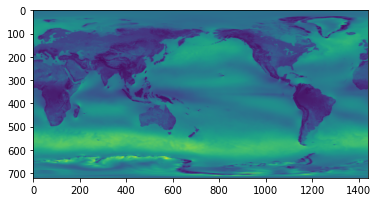

[output:2]

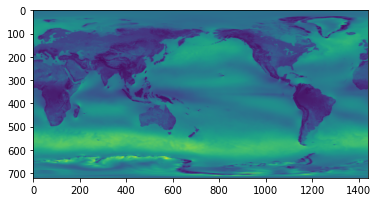

[output:1]

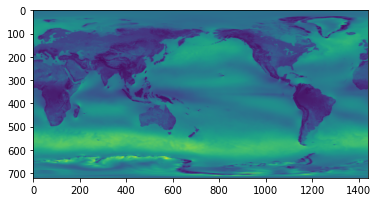

[output:0]

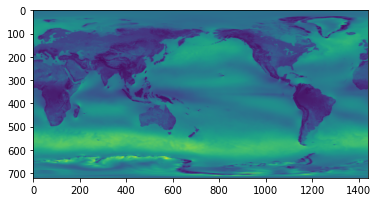

In [6]:
%%px
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(w_avg.numpy())
plt.show()

## Whats next? 

Within Heat, you have several options to apply memory-distributed machine learning algorithms on your data. Check out our dedicated notebooks on Clustering and PCA (with the JPL Dataset) or  Dynamic Mode Decomposition (with the tiny ERA5 data) for an example.



Is the algorithm you're looking for not yet implemented? [Let us know](https://github.com/helmholtz-analytics/heat/issues/new/choose)! 